In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt



from scripts.main_SurgeSplat import get_pointcloud,initialize_params,get_loss,initialize_optimizer,deform_gaussians
from utils.recon_helpers import setup_camera

from utils.slam_helpers import (
    transformed_params2rendervar, transformed_params2depthplussilhouette,
    transform_to_frame, l1_loss_v1, matrix_to_quaternion
)
from diff_gaussian_rasterization import GaussianRasterizer as Renderer

from models.SurgeDepth.dpt import SurgeDepth
import torchvision

System Paths:
/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM
/media/thesis_ssd/anaconda/envs/endogslam/lib/python310.zip
/media/thesis_ssd/anaconda/envs/endogslam/lib/python3.10
/media/thesis_ssd/anaconda/envs/endogslam/lib/python3.10/lib-dynload

/media/thesis_ssd/anaconda/envs/endogslam/lib/python3.10/site-packages


In [3]:
# plt.imshow(1/(disp.squeeze().cpu().detach()*0.1+1))
# plt.colorbar()

In [6]:
import cv2

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}
model = SurgeDepth(**model_configs['vitb']).cuda()
model.load_state_dict(torch.load('models/SurgeDepth/SurgeDepthStudent_V5.pth'))


color = cv2.imread('/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM/data/endonerf_cutting/images/frame-000000.color.png')
depth = cv2.imread('/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM/data/endonerf_cutting/depth/frame-000000.png')
color = cv2.resize(color, (336,336))
depth = cv2.resize(depth, (336,336))
color = cv2.cvtColor(color,cv2.COLOR_BGR2RGB)
color = torch.Tensor(color).permute(2,0,1).cuda()
color = (color-color.min())/(color.max()-color.min())


color_incoming = cv2.imread('/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM/data/endonerf_cutting/images/frame-000001.color.png')
depth_incoming = cv2.imread('/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM/data/endonerf_cutting/depth/frame-000001.png')
color_incoming = cv2.resize(color_incoming, (336,336))
depth_incoming = cv2.resize(depth_incoming, (336,336))
color_incoming = cv2.cvtColor(color_incoming,cv2.COLOR_BGR2RGB)
color_incoming = torch.Tensor(color_incoming).permute(2,0,1).cuda()
color_incoming = (color_incoming-color_incoming.min())/(color_incoming.max()-color_incoming.min())

depth = torch.Tensor(depth)[:,:,0].unsqueeze(0).cuda()*3+1
depth_incoming = torch.Tensor(depth_incoming)[:,:,0].unsqueeze(0).cuda()*5+2
with torch.no_grad():
    normalization_means = [0.46888983, 0.29536288, 0.28712815]
    normalization_stds = [0.24689102 ,0.21034359, 0.21188641]
    color_input = torchvision.transforms.functional.normalize(color,normalization_means,normalization_stds)
    disp = model(color_input.unsqueeze(0))
    depth = 1/(disp*0.005+0.5)


    color_input_incoming = torchvision.transforms.functional.normalize(color_incoming,normalization_means,normalization_stds)
    disp_incoming = model(color_input_incoming.unsqueeze(0))
    depth_incoming = 1/(disp*0.005+0.5)
# del model

intrinsics =  torch.tensor([[300., 0., 16.], [0., 300., 16.], [0., 0., 1.]]).cuda()
w2c = torch.eye(4).cuda()
cam = setup_camera(336, 336, intrinsics.cpu().numpy(), w2c.detach().cpu().numpy(), use_simplification=False)


pt_cloud,mean3_sq_dist= get_pointcloud(color,depth,intrinsics,w2c,compute_mean_sq_dist=True)
params,variables = initialize_params(pt_cloud,2,mean3_sq_dist)
# Initialize Mapping Data for selected frame
curr_data = {'cam': cam, 'im': color_incoming, 'depth': depth_incoming, 'id': 1, 'intrinsics': intrinsics, 
                'w2c': w2c, 'iter_gt_w2c_list': w2c}
loss_weights=dict(
    im=1.5,
    depth=0.0,
)

lrs=dict(
    means3D=0.0,
    rgb_colors=0.00,
    unnorm_rotations=0.0,
    logit_opacities=0.0,
    log_scales=0.0,
    cam_unnorm_rots=0.001,
    cam_trans=0.001,
    deform_weights = 0.01,
    deform_stds = 0.01,
    deform_biases = 0.01,
)


optimizer = initialize_optimizer(params,lrs_dict=lrs)
param_list = []
print(params['deform_weights'].max())
for iter in range(100):
    optimizer.zero_grad()
    loss, variables, losses = get_loss(params, curr_data, variables, iter_time_idx=1,loss_weights=loss_weights,use_sil_for_loss=True,sil_thres=0.99,
                                       use_l1=True,ignore_outlier_depth_loss=False,tracking=True,mapping=False,do_ba=False,
                                       plot_dir = False,visualize_tracking_loss=False,tracking_iteration=None,use_gt_depth=False,gaussian_deformations=True,save_idx = iter)
    loss.backward()
    
    optimizer.step()
    
    # print(params['means3D'].grad)
    weights_store = params['deform_weights'].detach()
    stds_store = params['deform_biases'].detach()
    param_list.append(weights_store)

    print(loss.item())
print(params['deform_weights'].max())
print(param_list[0].max(),param_list[14].max())

INFO:dinov2:using MLP layer as FFN


tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
10597.9921875
9884.1689453125
8386.099609375
6665.4658203125
6190.8251953125
5716.2666015625
4456.83056640625
3486.18603515625
3551.934814453125
3537.72509765625
3061.30419921875
2603.8984375
2788.69140625
2893.80078125
2574.64697265625
2220.56787109375
2308.61376953125
2338.147705078125
2096.4453125
1989.98388671875
2100.4453125
2018.00244140625
1812.0926513671875
1822.5479736328125
1818.730712890625
1697.67626953125
1715.5096435546875
1716.0626220703125
1605.6947021484375
1603.798828125
1579.169677734375
1531.7210693359375
1549.1517333984375
1481.5858154296875
1472.316162109375
1452.2890625
1442.1470947265625
1442.4151611328125
1393.99755859375
1396.1466064453125
1394.587890625
1397.66064453125
1365.1739501953125
1362.3878173828125
1368.5
1346.5875244140625
1346.588134765625
1342.1240234375
1347.7818603515625
1340.785888671875
1347.41357421875
1344.0914306640625
1358.343994140625
1387.041748046875
1404.92333984375
1354.0577392578125

In [9]:
color.max()

tensor(1., device='cuda:0')

In [5]:
iter_time_idx = 1
for param in param_list:
    local_means,local_rots,local_scales = deform_gaussians(param,iter_time_idx,deform_grad = True)
    transformed_pts = transform_to_frame(local_means,param, iter_time_idx, 
                                             gaussians_grad=False,
                                             camera_grad=True)
    rendervar = transformed_params2rendervar(param, transformed_pts,local_rots,local_scales)
    # depth_sil_rendervar = transformed_params2depthplussilhouette(params, curr_data['w2c'],
                                                                #  transformed_pts,local_rots,local_scales)
    im, radius, _ = Renderer(raster_settings=curr_data['cam'])(**rendervar)
    # depth_sil, _, _ = Renderer(raster_settings=curr_data['cam'])(**depth_sil_rendervar)
    # plt.imshow(im.permute(1,2,0).cpu().detach())
    # plt.show()


IndexError: too many indices for tensor of dimension 3

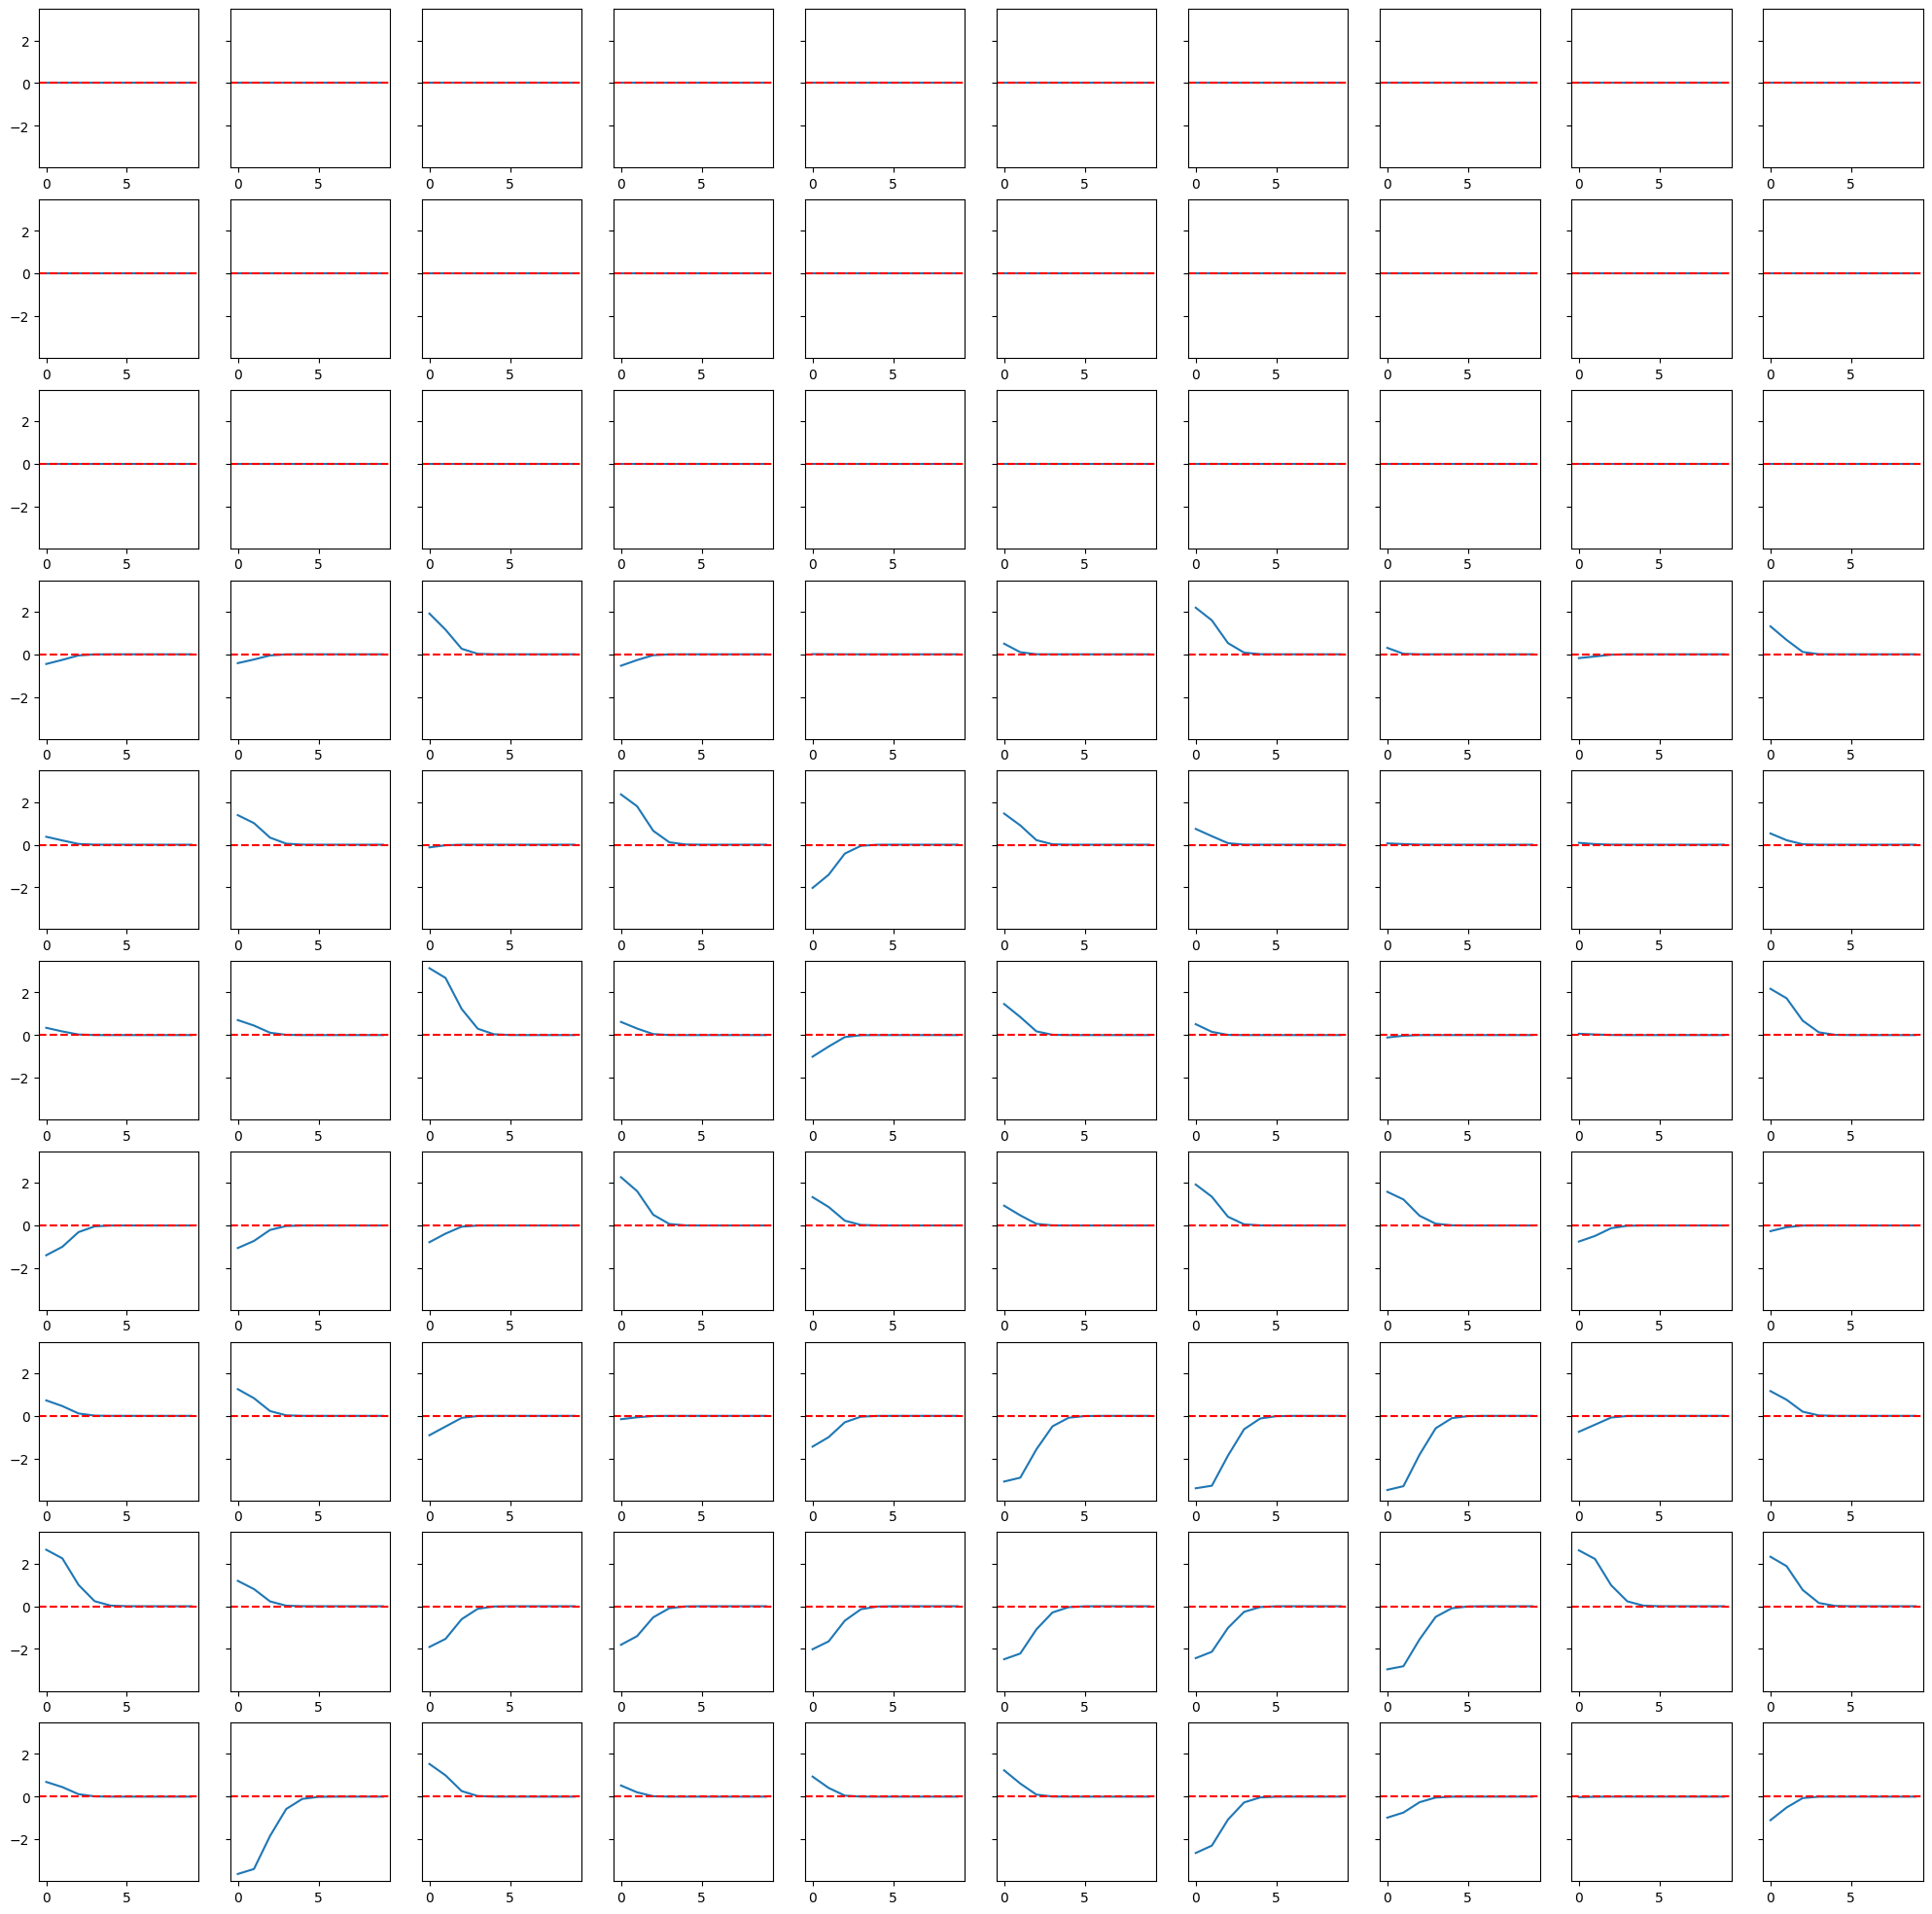

In [ ]:
weights =   params['deform_weights'].cpu().detach()
biases =    params['deform_biases'].cpu().detach()
stds =      params['deform_stds'].cpu().detach()

deforms = []
deformsx1 = []
for time in range(10):
    deform = torch.sum(weights*torch.exp(-1/(2*stds**2)*(time-biases)**2),1)
    deforms.append(deform) # Nx10 gaussians deformations
    deformsx1.append(deform[0,0])
fig,ax = plt.subplots(10,10,figsize = (25,25),sharey=True)
for i in range(10):
    for ii in range(10):
        ax[ii,i].plot([deforms[idx][i+10,ii] for idx in range(len(deforms))])
        ax[ii,i].axhline(y = 0.0,color = 'r', linestyle = '--')    

In [ ]:
(param_list[0]['means3D']-param_list[14]['means3D']).max()

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)

In [3]:
import torch
import matplotlib.pyplot as plt
torch.arange(0,100,10).shape

torch.Size([10])

In [4]:
total_timescale = torch.tensor(99)
nr_basis = 15
interval = torch.ceil(total_timescale/nr_basis)
arange = torch.arange(0,total_timescale,interval).unsqueeze(0).unsqueeze(-1)
nr_gaussians = 123
biases = torch.tile(arange,(nr_gaussians,1,10))
biases.shape

torch.Size([123, 15, 10])

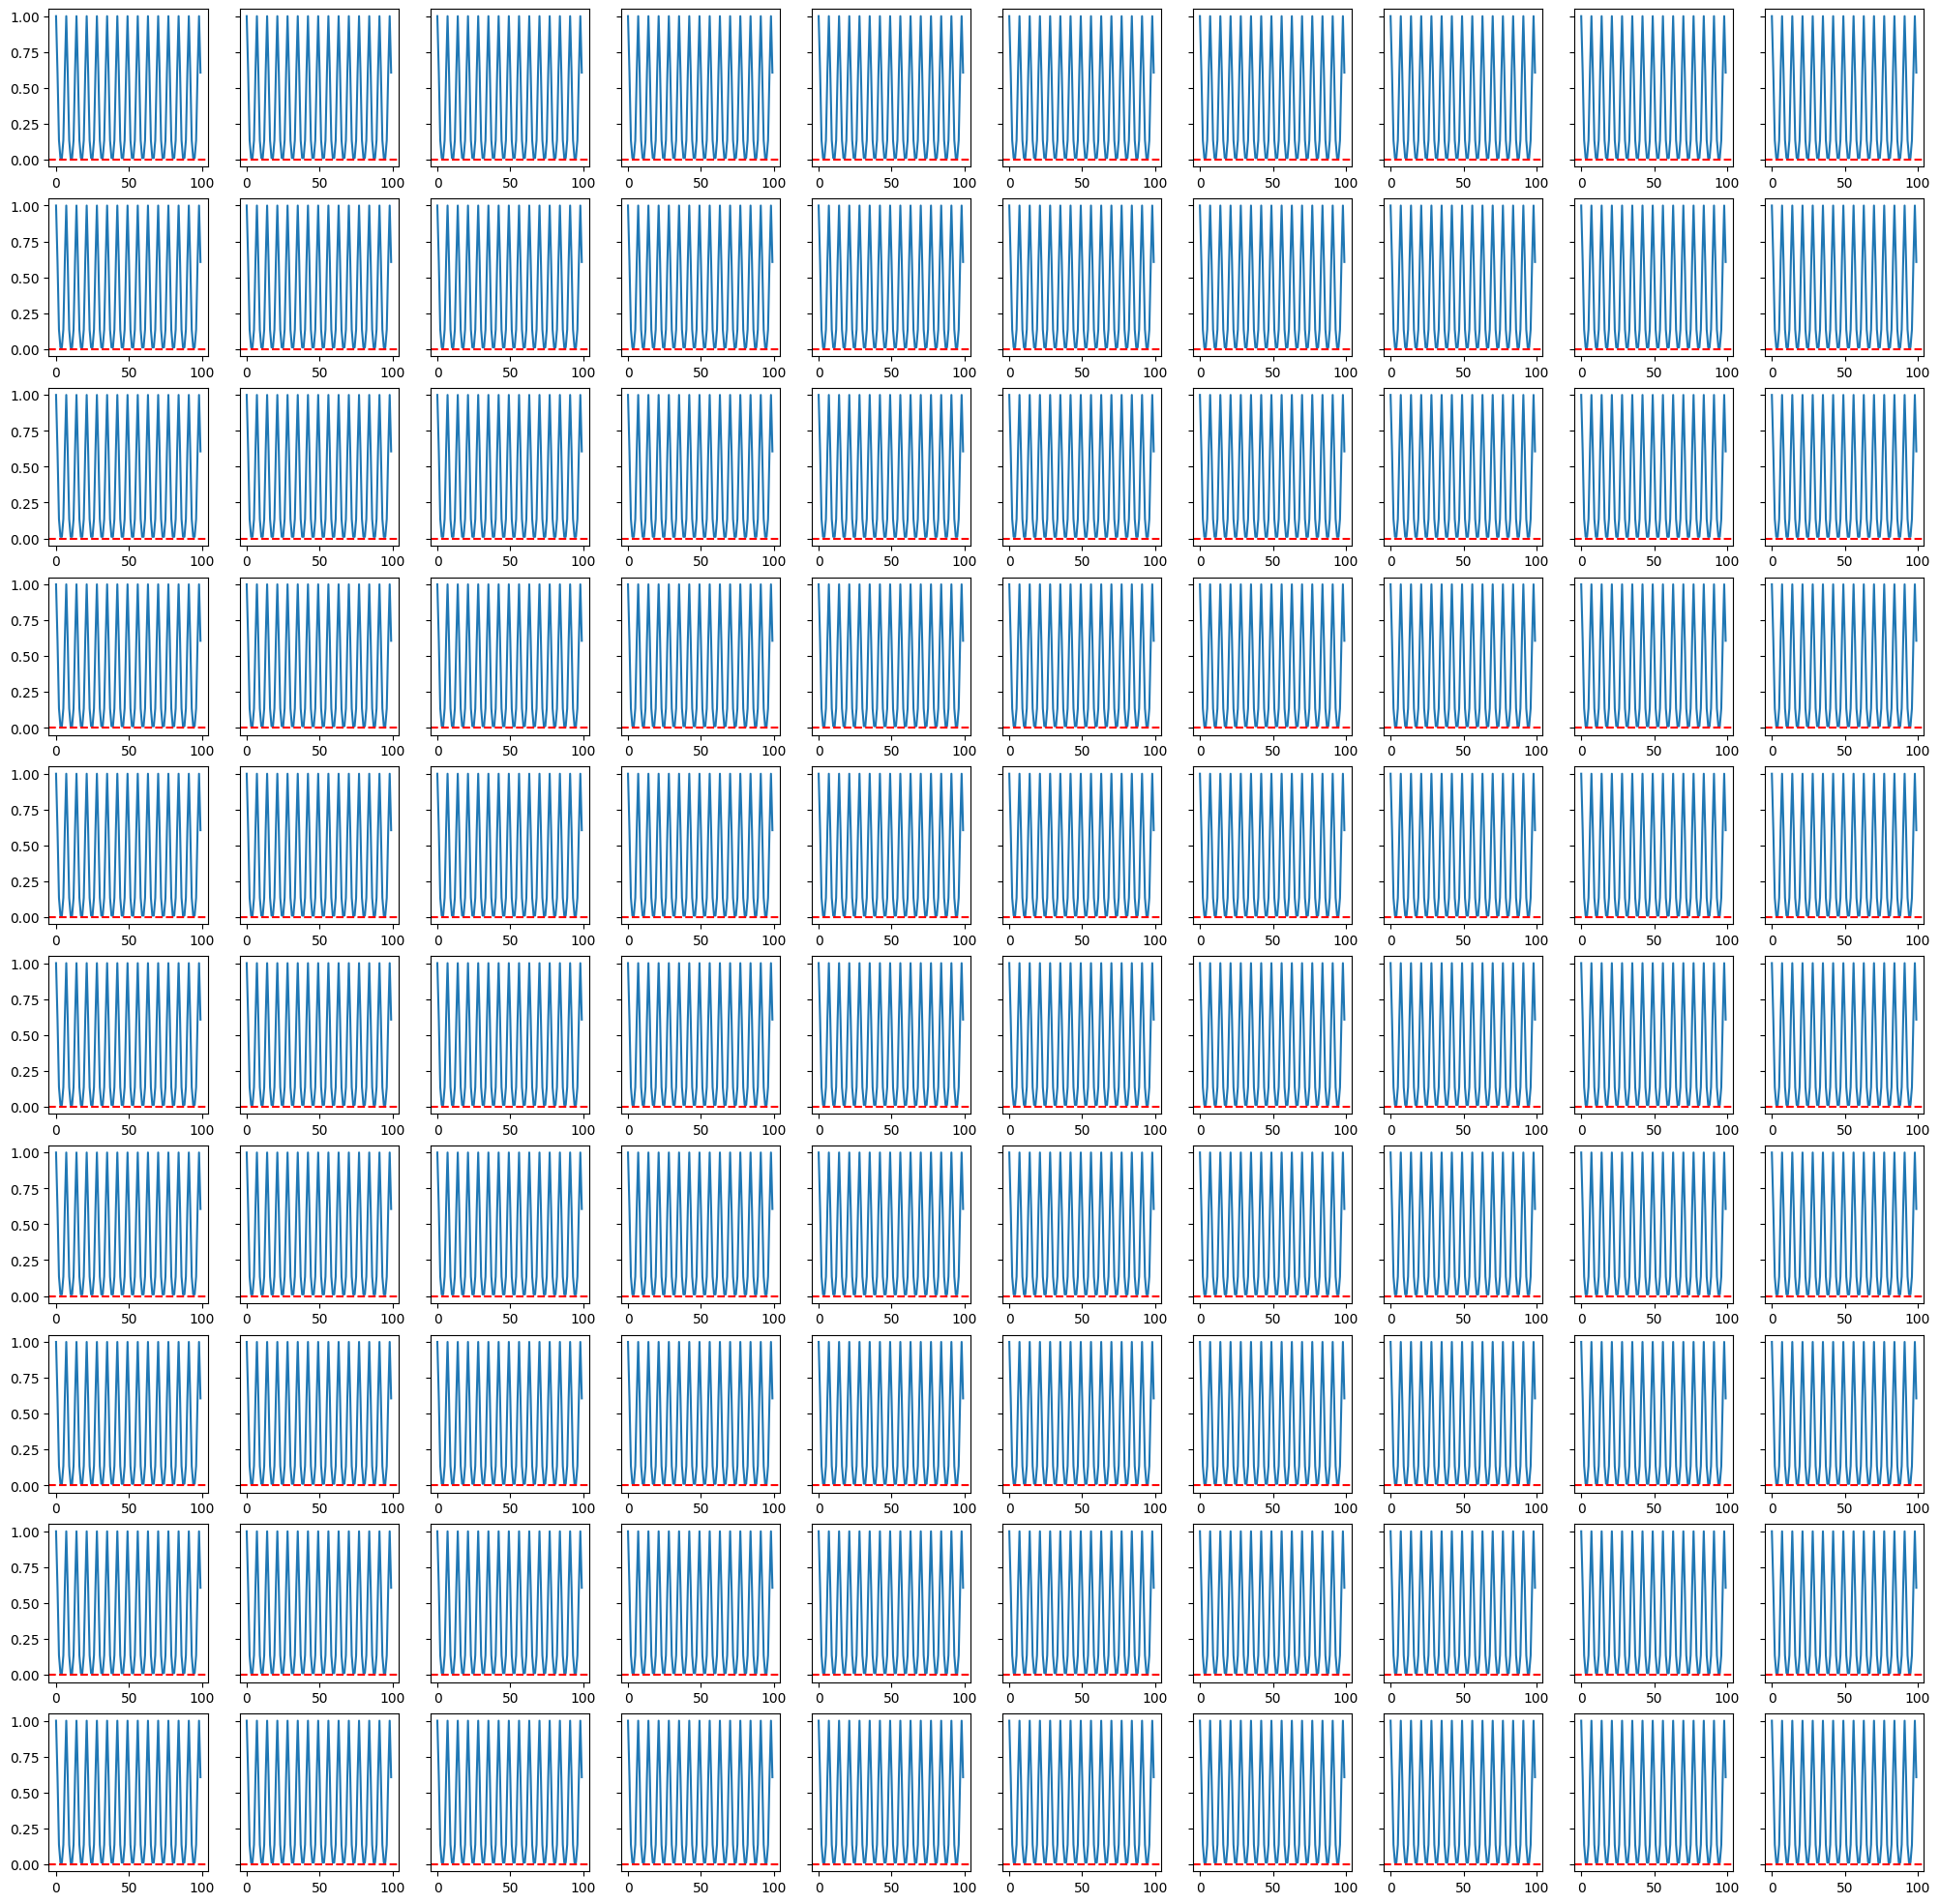

In [18]:
weights = torch.ones((nr_gaussians,nr_basis,10))
biases =biases
stds =torch.ones((nr_gaussians,nr_basis,10))

deforms = []
deformsx1 = []
for time in range(100):
    deform = torch.sum(weights*torch.exp(-1/(2*stds**2)*(time-biases)**2),1)
    deforms.append(deform) # Nx10 gaussians deformations
    deformsx1.append(deform[0,0])
fig,ax = plt.subplots(10,10,figsize = (25,25),sharey=True)
for i in range(10):
    for ii in range(10):
        ax[ii,i].plot([deforms[idx][i+10,ii] for idx in range(len(deforms))])
        ax[ii,i].axhline(y = 0.0,color = 'r', linestyle = '--')    

In [17]:
deform_0 = torch.sum(weights*torch.exp(-1/(2*stds**2)*(0-biases)**2),1)
deform_0.shape

torch.Size([123, 10])